# Getting Started with `mimopy`

In this notebook, we'll go through the installation and basic usage of the `mimopy` package.

In [31]:
# install the package with pip install
%pip install git+https://github.com/WirelessLabAtUCLA/mimopy.git

In [32]:
# import packages
import numpy as np
from mimopy import AntennaArray
from mimopy.channels import LoS, Rician, SphericalWave
import matplotlib.pyplot as plt

%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## Create Antenna Arrays

In [33]:
Nt = 8  # number of transmit antennas
Nr = 8  # number of receive antennas

# coordinates of the transmit antenna array in x, y, z, unit is wavelength
tx_coords = (0, 20, 0)
# coordinates of the receive antenna array in x, y, z, unit is wavelength
rx_coords = (0, 0, 0)

tx_power = 20  # transmit power in dBm
rx_power = 10  # receive power in dBm

tx_noise_power = 0  # noise power in dBm
rx_noise_power = 0  # noise power in dBm

# create uniform linear arrays (ULA) along the x-axis
tx = AntennaArray.ula(
    N=Nt,
    name="TX",
    array_center=tx_coords,
    power_dbm=tx_power,
    noise_power_dbm=tx_noise_power,
    ax="x",
)

rx = AntennaArray.ula(
    N=Nr,
    name="RX",
    array_center=rx_coords,
    power_dbm=rx_power,
    noise_power_dbm=rx_noise_power,
    ax="x",
)

# check the power of the antenna arrays
print(f"TX power in linear scale: {tx.power} mW, in dBm: {tx.power_dbm} dBm")
print(f"RX power in linear scale: {rx.power} mW, in dBm: {rx.power_dbm} dBm")

TX power in linear scale: 100.0 mW, in dBm: 20.0 dBm
RX power in linear scale: 10.0 mW, in dBm: 10.0 dBm


The weights of the antenna array is defulted to be uniform.

In [34]:
print(f"TX array weights: {tx.weights}")
print(f"RX array weights: {rx.weights}")

TX array weights: [1. 1. 1. 1. 1. 1. 1. 1.]
RX array weights: [1. 1. 1. 1. 1. 1. 1. 1.]


You can visualize the antenna array and the channel by calling `plot_array` and `plot_array_3d`.

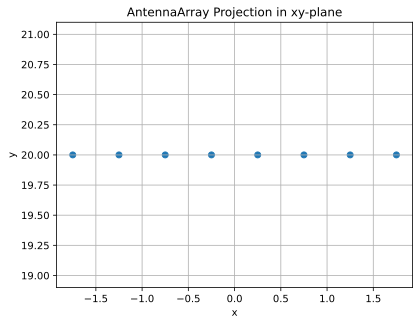

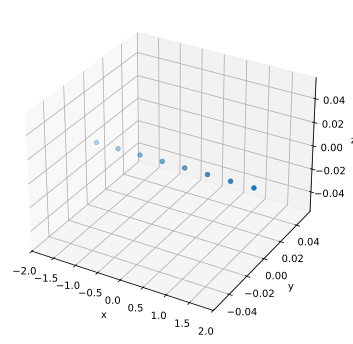

In [35]:
tx.plot_array(plane="xy")
rx.plot_array_3d()

<PolarAxes: title={'center': 'el = 0 deg, max gain = 18.06 dB'}, xlabel='Azimuth (deg)', ylabel='Gain (dB)'>

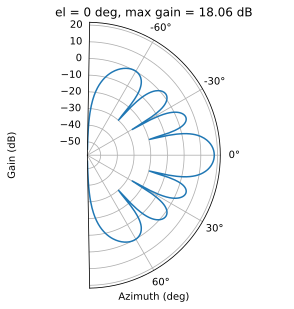

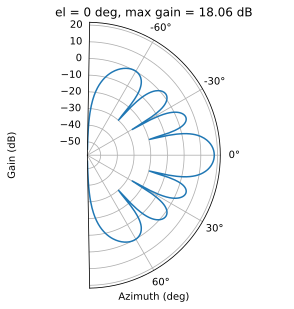

In [36]:
tx.plot_gain()
rx.plot_gain()

## Create channels

The channels are created by calling the channel function. Note: you need to manually call `realize` to generate the channel realizations.

In [37]:
# create a LoS channel between the transmit and receive antenna arrays

los_channel = LoS(tx=tx, rx=rx, path_loss="no_loss")

# you need to realize the channel to get the channel matrix
print(f"First column of channel matrix before realization: \n{los_channel.H[0]}\n")
los_channel.realize()

print(f"First column of channel matrix after realization: \n{los_channel.H[:, 0]}")

First column of channel matrix before realization: 
[-1.-0.j -1.-0.j -1.-0.j -1.-0.j -1.-0.j -1.-0.j -1.-0.j -1.-0.j]

First column of channel matrix after realization: 
[ 1.+0.00000000e+00j -1.-1.22464680e-16j  1.+2.44929360e-16j
 -1.-3.67394040e-16j  1.+4.89858720e-16j -1.-6.12323400e-16j
  1.+7.34788079e-16j -1.-8.57252759e-16j]


Inspect the SNR

In [41]:
print(f"SNR in dB: {los_channel.snr_db:.2f}, SNR in linear scale: {los_channel.snr:.2f}")

SNR in dB: -606.14, SNR in linear scale: 0.00


Note that the SNR is quite low. It's because the default beamforming weights fall into the nulls of the channel. We can change that by using conjugate beamforming.

In [43]:
conj_weights = los_channel.H[0].conj()
tx.set_weights(conj_weights)
rx.set_weights(conj_weights)

print(f"SNR after conjugate beamforming: {los_channel.snr_db:.2f} dB")

SNR after conjugate beamforming: 38.06 dB


In this case, conjugate beamforming is optimal.The new SNR matches the theoretical SNR upper bound via the matched filter on the channel.

In [45]:
print(f"Theoretical SNR upper bound: {los_channel.snr_upper_bound_db:.2f} dB")

Theoretical SNR upper bound: 38.06 dB


we can check the new gain pattern of the antenna array by calling `plot_gain`

<PolarAxes: title={'center': 'el = 0 deg, max gain = 18.06 dB'}, xlabel='Azimuth (deg)', ylabel='Gain (dB)'>

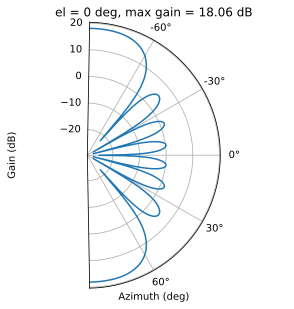

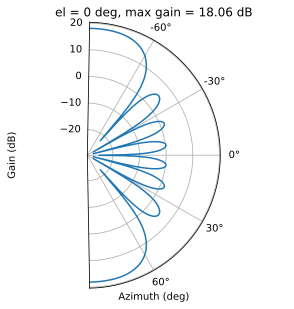

In [56]:
tx.plot_gain()
rx.plot_gain(cut=0, cut_along="el")